## This is the notebook used during the first campaign of M1M3 testing
## First time we applied these forces was late afternoon of Tuesday 1/15/19.
## This doesn't take into account the non-zero lateral actuator load (see document-32392)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
BuddyFile = '../data/optimizedShapeML/LSST M1M3 nominal forces + 22mode correction forces 141019-21.xlsx'
df = pd.read_excel(BuddyFile)

In [4]:
BuddyForce = np.float64(df['net force'][1:])
staticForce = np.float64(df['correction force'][1:])
# Buddy's actuator IDs are different, not in ascending order
BuddyActID = np.float64(df['actuator ID'][1:])
BuddyActX = np.float64(df['x'][1:])
BuddyActY = np.float64(df['y'][1:])

In [5]:
#get rid of the zeros in below Buddy's rows in the Excel
idx00 = ~np.isnan(BuddyForce) 
BuddyForce = BuddyForce[idx00]
staticForce = staticForce[idx00]
BuddyActID = BuddyActID[idx00]
BuddyActX = BuddyActX[idx00]
BuddyActY = BuddyActY[idx00]

In [6]:
idxAs = np.argsort(BuddyActID)
actIDsorted = BuddyActID[idxAs]
BuddyForce = BuddyForce[idxAs]
staticForce = staticForce[idxAs]
xact = BuddyActX[idxAs]
yact = BuddyActY[idxAs]

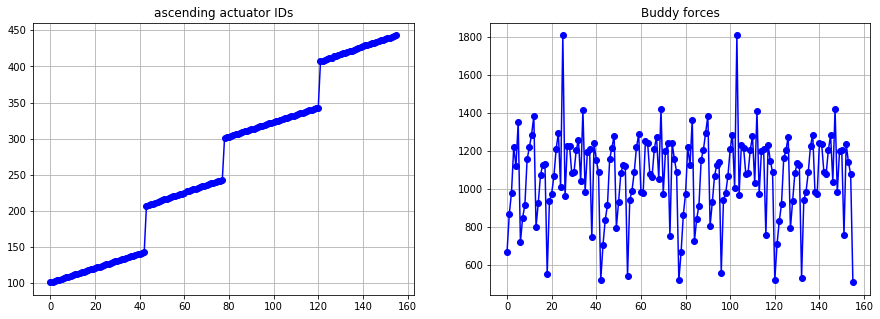

In [14]:
fig, ax = plt.subplots(1,2, figsize = (15,5))
#check this is indeed in ascending order now
ax[0].plot(actIDsorted,'-bo')
ax[0].set_title('ascending actuator IDs')
ax[0].grid()
ax[1].plot(BuddyForce,'-bo')
ax[1].set_title('Buddy forces')
ax[1].grid()

In [7]:
actTypeFile = '../data/LS_CUP_ACTSTYLE_ID.xlsx'
df = pd.read_excel(actTypeFile)
#df.keys()
idx00 = ~np.isnan(np.float64(df['Unnamed: 8'][1:])) #actuator ID column

In [8]:
actType = df['Unnamed: 12'][1:][idx00]
cupType = df['Unnamed: 13'][1:][idx00]
puckType = df['Unnamed: 11'][1:][idx00]
nActuator = actType.shape[0]

In [9]:
# subtraction: hardware that were removed after the 2014 testing
subtractF = np.zeros(nActuator)
# for each actuator
subtractF = subtractF + 50.8023*9.8/(156+4) #112 lbs is 50.8023 kilograms
# for Quads, this needs to be doubled, so, add again.
idx = puckType =='Quad Puck'
subtractF[idx] = subtractF[idx] + 50.8023*9.8/(156+4)
print('Removed 160 interface plates (each Quad had 2 plates), total is 112lb, according to Steve West')

# additional plates that was removed.
subtractF[idx] = subtractF[idx] + 0.378*9.8/5*(25.4/4) #scaled, from 5mm to 1/4"
print('Additional plates removed from %d Quads'%sum(idx))
print('\t each 0.378 kg when they were 5mm thick. The actual thickness is 1/4 inch')
idx = puckType =='Triple Puck'
subtractF[idx] = subtractF[idx] + 0.378*9.8/5*(25.4/4)
print('Additional plates removed from %d Triples'%sum(idx))
print('\t each 0.378 kg when they were 5mm thick. The actual thickness is 1/4 inch')

# add up our subtraction by hand (in kg)
subtractFsum = (50.8023 + 0.378/5*(25.4/4) * (114 +4))*9.8
print(subtractFsum, ' == ?? == ' , sum(subtractF))

Removed 160 interface plates (each Quad had 2 plates), total is 112lb, according to Steve West
Additional plates removed from 4 Quads
	 each 0.378 kg when they were 5mm thick. The actual thickness is 1/4 inch
Additional plates removed from 114 Triples
	 each 0.378 kg when they were 5mm thick. The actual thickness is 1/4 inch
1053.003924  == ?? ==  1053.0039239999985


In [10]:
# according to "additional actuator mass.pptx" by Ed Hileman
mDAA = 1.51 # kg
mSAA2 = 0.97465 #kg
mSAA1 = 0.78617  #kg
mIC1 = 1.23  #kg
mIC2 = 1.85  #kg
mIP = 103.41e-3   #kg, each, for interface plates
addF = np.zeros(nActuator)
idx = actType == 'DAA'
addF[idx] = addF[idx] + mDAA*9.8
print('Added %d DAA actuators, each weigh %.5f kg'%(sum(idx), mDAA))
idx = actType == 'SAA-1'
addF[idx] = addF[idx] + mSAA1*9.8
print('Added %d SAA-1 actuators, each weigh %.5f kg'%(sum(idx), mSAA1))
idx = actType ==  'SAA-2'
addF[idx] = addF[idx] + mSAA2*9.8
print('Added %d SAA-2 actuators, each weigh %.5f kg'%(sum(idx), mSAA2))
idx = cupType == 'small flange'
addF[idx] = addF[idx] +mIC1*9.8
print('Added %d interface cup - 1, each weigh %.5f kg'%(sum(idx), mIC1))
idx = cupType == 'large flange'
addF[idx] = addF[idx] +mIC2*9.8
print('Added %d interface cup - 2, each weigh %.5f kg'%(sum(idx), mIC2))

idx = puckType == 'Triple Puck'
addF[idx] = addF[idx] +mIP*9.8*3
print('Added %d interface plates on triple puck actuators, each weigh %.5f kg'%(sum(idx)*3, mIP))
idx = puckType == 'Quad Puck'
addF[idx] = addF[idx] +mIP*9.8*4
print('Added %d interface plates on quad puck actuators, each weigh %.5f kg'%(sum(idx)*4, mIP))
#ID 238 is a triple puck, but was modified to have 4 interface plates
idx = actIDsorted ==238
addF[idx] = addF[idx] +mIP*9.8*1
print('Modified %d triple puck actuator to have 4 interface plates, each interface plate weight %.5f kg'%(1,mIP))
addFsum = (1.51*112+0.97465*6+0.78617*38+1.23*114+1.85*4+0.10341*(114*3+4*4+1))*9.8
print(addFsum, ' == ?? == ', sum(addF))

Added 112 DAA actuators, each weigh 1.51000 kg
Added 38 SAA-1 actuators, each weigh 0.78617 kg
Added 6 SAA-2 actuators, each weigh 0.97465 kg
Added 114 interface cup - 1, each weigh 1.23000 kg
Added 4 interface cup - 2, each weigh 1.85000 kg
Added 342 interface plates on triple puck actuators, each weigh 0.10341 kg
Added 16 interface plates on quad puck actuators, each weigh 0.10341 kg
Modified 1 triple puck actuator to have 4 interface plates, each interface plate weight 0.10341 kg
3817.94819  == ?? ==  3817.948189999997


In [16]:
knownF = BuddyForce + addF - subtractF
knownF0 = knownF.copy() #knownF0: without scaling, our best knowledge
ChrisFtot = 172741.583  # in Newtons. from Chris.
knownF = knownF/sum(knownF)*ChrisFtot
print('sum of all the known forces: %.0f N'%(sum(knownF0) ))

sum of all the known forces: 168905 N


In [14]:
print(ChrisFtot - sum(knownF0))

3836.366940165608


In [20]:
# Chris is set up to apply the 2014 static forces already.
# and, Ed is working on the FEA, he doesn't need these static forces. So I was asked to take it out
knownF -= staticForce

In [21]:
# Chris' forces on the Friday before testing started (I need to follow the same format)
ChrisFile = '../data/optimizedShapeML/ElevationZTableMirrorLab-20190111a.csv'
df = pd.read_csv(ChrisFile)
ChrisForce = df['Coefficient 0'].copy()

In [22]:
df['Coefficient 0'] = knownF

In [16]:
BoFile = '../data/optimizedShapeML/InitialForces_190115_Bo2.csv'
df.to_csv(BoFile)

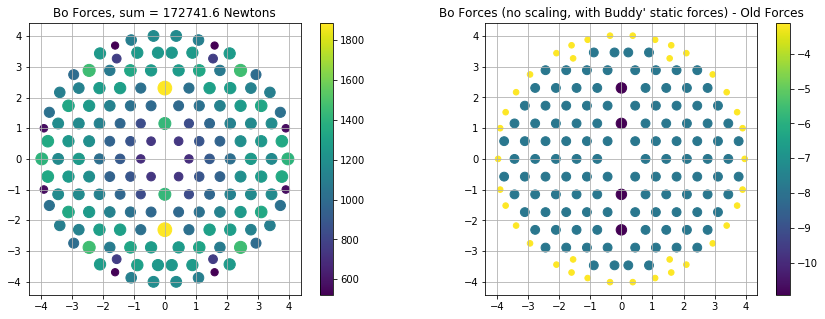

In [17]:
fig, ax = plt.subplots(1,2, figsize = (15,5))
#check this is indeed in ascending order now
img = ax[0].scatter(xact, yact, knownF/10, knownF)
ax[0].set_title('Bo Forces, sum = %.1f Newtons'%sum(knownF))
ax[0].grid()
x0,x1 = ax[0].get_xlim()
y0,y1 = ax[0].get_ylim()
ax[0].set_aspect(abs(x1-x0)/abs(y1-y0))
fig.colorbar(img, ax = ax[0])
img = ax[1].scatter(xact, yact, abs(knownF0-ChrisForce)*10, knownF0-ChrisForce)
ax[1].set_title('Bo Forces (no scaling, with Buddy\' static forces) - Old Forces')
ax[1].grid()
x0,x1 = ax[1].get_xlim()
y0,y1 = ax[1].get_ylim()
ax[1].set_aspect(abs(x1-x0)/abs(y1-y0))
fig.colorbar(img, ax = ax[1])

In [23]:
# this is Chris' applied forces when we added 350N to two quads and 200N to the other two quads (they were then clipped)
# I don't have the forces applied after he removed the 350N and 200N
ChrisAppliedFile = '../data/optimizedShapeML/ElevationZTableMirrorLab-20190114a.csv'
df = pd.read_csv(ChrisAppliedFile)
ChrisApplied = df['Coefficient 0']

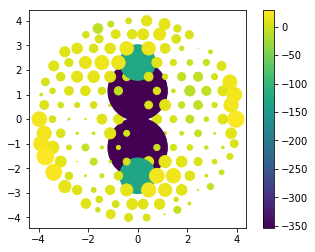

In [31]:
plt.scatter(xact, yact, abs(knownF-ChrisApplied)*10, (knownF-ChrisApplied))
x0,x1 = plt.xlim()
y0,y1 = plt.ylim()
plt.axes().set_aspect(abs(x1-x0)/abs(y1-y0))
plt.colorbar()

In [24]:
print(sum(knownF), sum(ChrisForce), sum(ChrisApplied))

172741.5812075001 169958.23100000003 172803.09199999992


In [30]:
print('Fz=%.0f N'%sum(knownF))
print('Mx=%.0f N*m'%sum(knownF*yact))
print('My=%.0f N*m'%sum(knownF*xact))

Fz=172742 N
Mx=-347 N*m
My=-29 N*m


In [31]:
print('Fz=%.0f N'%sum(BuddyForce))
print('Mx=%.0f N*m'%sum(BuddyForce*yact))
print('My=%.0f N*m'%sum(BuddyForce*xact))

Fz=166140 N
Mx=-336 N*m
My=-27 N*m


In [32]:
knownF

array([ 707.62881756,  909.78354177, 1014.42484117, 1261.30910479,
       1169.07395561, 1401.90542001,  740.20277908,  886.83227175,
        953.25760891, 1195.5845552 , 1263.34007908, 1342.67766376,
       1429.21421099,  834.06912291,  970.52039086, 1116.68224059,
       1169.44645961, 1175.50379704,  572.24529182,  985.34052624,
       1029.81599892, 1120.02776095, 1258.08425153, 1340.88019806,
       1031.40514559, 1885.74772633, 1020.7815141 , 1290.20822005,
       1281.89091426, 1122.05352601, 1105.08704466, 1266.02285762,
       1320.11088171, 1088.96720132, 1462.45831205, 1000.8332882 ,
       1248.60432264, 1261.66476924,  765.10904889, 1261.22308001,
       1177.00427112, 1106.56591605,  525.91726134,  738.75063855,
        887.10485709,  952.43315727, 1195.53802549, 1262.63195175,
       1339.58576087,  834.87205923,  969.96359229, 1115.78989069,
       1167.0519888 , 1173.53086931,  571.49827479,  985.40944545,
       1029.2045785 , 1122.12720279, 1258.07297225, 1340.81108